In [1]:
from torch.utils.data import Dataset,DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import time

In [2]:
class MultiLayerPerceptron(nn.Module):
    def __init__(self, input_size, mid_size, out_size, mid_layers):
        super().__init__()
        self.mid_layers = mid_layers
        self.fc = nn.Linear(input_size, mid_size)#線変換する
        self.fc_mid = nn.Linear(mid_size, mid_size)
        self.fc_out = nn.Linear(mid_size, out_size)
        self.bn = nn.BatchNorm1d(mid_size)#バッチ正規化の適用
    def forward(self, x):
        x = F.relu(self.fc(x))
        """
        reru(レルー)とは
        関数の入力値が0以下:出力値が0
        関数の入力値が0より大きい:そのまま入力値が出力する
        """
        for _ in range (self.mid_layers):#この変数は使わないですよー
            """
            https://zero2one.jp/ai-word/multi-layer-perceptron/
            順伝播をしている
            ①各層の重み，バイアスを適当な乱数で初期化
            ②前層の出力から次の層の出力を計算する作業を繰り返し最終的な出力結果を得る
            ③最終的な出力値に対するコスト関数を計算
            """
            x = F.relu(self.bn(self.fc_mid(x)))#中間層をバッチ正規化して，活性化関数に入れる
        x = F.relu(self.fc_out(x))
        return x
        

In [3]:
x_train = torch.load("X_train.pt")
model = MultiLayerPerceptron(300, 200, 4, 1)

In [4]:
class NewsDataset(Dataset):
    def __init__(self, x, y):
        self.x = x#NewsDataset
        self.y = y
    
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return [self.x[idx], self.y[idx]]

In [5]:
def calc_acc(model, loader, device):
    model.eval()#評価モードにする
    total = 0
    correct = 0
    with torch.no_grad():#勾配計算を不可にしてメモリ消費を減らす
        for inputs,labels in loader:
            inputs = inputs.to(device)#デバイスに移動
            labels = labels.to(device)
            outputs = model(inputs)
            pred = torch.argmax(outputs, dim=-1)#outputsの最大値のインデックス
            total += len(inputs)
            correct += (pred == labels).sum().item()
        
        return correct / total#正解率の計算

In [22]:
def calc_loss_acc(model, criterion, loader, device):
    model.eval()
    loss = 0.0
    total = 0
    correct = 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)#デバイスに移動
            labels = labels.to(device)
            outputs = model(inputs)
            loss += criterion(outputs, labels).item()#損失関数をoutputsとラベルを入れて損失を計算する
            pred = torch.argmax(outputs, dim=-1)
            total += len(inputs)
            correct += (pred == labels).sum().item()
        
        return loss/len(loader), correct/total#平均損失，正解率

In [23]:
X_train = torch.load("X_train.pt")
y_train = torch.load("Y_train.pt")
X_valid = torch.load("X_valid.pt")
y_valid = torch.load("Y_valid.pt")
X_test = torch.load("X_test.pt")
y_test = torch.load("Y_test.pt")

In [24]:
dataset_train = NewsDataset(X_train, y_train)
dataset_valid = NewsDataset(X_valid, y_valid)
dataset_test = NewsDataset(X_test, y_test)

In [25]:
dataloader_train = DataLoader(dataset_train, batch_size=1, shuffle=True)
dataloader_valid = DataLoader(dataset_valid, batch_size=len(dataset_valid), shuffle=False)
dataloader_test = DataLoader(dataset_test, batch_size=len(dataset_test), shuffle=False)

In [26]:
log_train = []
log_valid = []

In [30]:
def train_model(dataset_train, dataset_valid, batch_size, model, criterion, num_epochs, device=None):
    model.to(device)
    dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
    dataloader_valid = DataLoader(dataset_valid, batch_size=len(dataset_valid), shuffle=False)

    for epoch in range(num_epochs):
        start_time = time.time()#開始時間

        model.train()
        loss_train = 0.0
        for inputs, labels in dataloader_train:
            optimizer.zero_grad()

            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model.forward(inputs)#順伝播
            loss = criterion(outputs, labels)#損失関数
            loss.backward()
            optimizer.step()
        end_time = time.time()#終了時間

        loss_train, acc_train = calc_loss_acc(
            model, criterion, dataloader_train, device)
        loss_valid, acc_valid = calc_loss_acc(
            model, criterion, dataloader_valid, device)
        log_train.append([loss_train, acc_train])
        log_valid.append([loss_valid, acc_valid])

        torch.save({
            "epoch": epoch,
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict()
            }, f"checkpoint{epoch + 1}.pt")
        
        print(f"epoch: {epoch+1}\n"+
              f"loss_train: {loss_train:.4f}\n" +
              f"accuracy_train: {acc_train:.4f}\n" +
              f"loss_valid: {loss_valid:.4f}\n" +
              f"accuracy_valid: {acc_valid:.4f}\n" +
              f"train_time: {(end_time - start_time):.4f}sec\n" +
              "------")

In [31]:
model = MultiLayerPerceptron(300, 200, 4, 1)
criterion = nn.CrossEntropyLoss()
#.parameters()モジュールパラメーターズのイテレーター
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
num_epochs = 50
device = torch.device("mps")
batch_size = 64
train_model(dataset_train, dataset_valid,
            batch_size, model, criterion, num_epochs, device)


epoch: 1
loss_train: 0.2462
accuracy_train: 0.9144
loss_valid: 0.3205
accuracy_valid: 0.8846
train_time: 0.4456sec
------
epoch: 2
loss_train: 0.2045
accuracy_train: 0.9309
loss_valid: 0.3163
accuracy_valid: 0.8973
train_time: 0.7746sec
------
epoch: 3
loss_train: 0.1826
accuracy_train: 0.9363
loss_valid: 0.3068
accuracy_valid: 0.8936
train_time: 0.7488sec
------
epoch: 4
loss_train: 0.1555
accuracy_train: 0.9491
loss_valid: 0.3361
accuracy_valid: 0.8883
train_time: 0.6360sec
------
epoch: 5
loss_train: 0.1498
accuracy_train: 0.9496
loss_valid: 0.3361
accuracy_valid: 0.8726
train_time: 0.5818sec
------
epoch: 6
loss_train: 0.1060
accuracy_train: 0.9660
loss_valid: 0.3127
accuracy_valid: 0.8973
train_time: 0.5736sec
------
epoch: 7
loss_train: 0.0816
accuracy_train: 0.9748
loss_valid: 0.3264
accuracy_valid: 0.8988
train_time: 0.6155sec
------
epoch: 8
loss_train: 0.1312
accuracy_train: 0.9506
loss_valid: 0.3991
accuracy_valid: 0.8718
train_time: 0.6426sec
------
epoch: 9
loss_train: 0.0

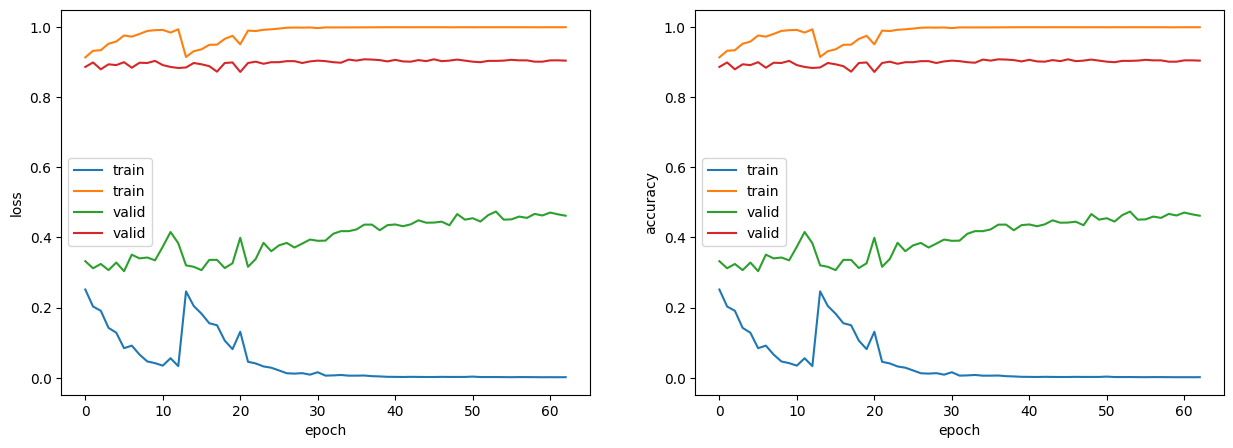

In [32]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(np.array(log_train), label="train")
ax[0].plot(np.array(log_valid), label="valid")
ax[0].set_xlabel("epoch")
ax[0].set_ylabel("loss")
ax[0].legend()#凡例表示

ax[1].plot(np.array(log_train), label="train")
ax[1].plot(np.array(log_valid), label="valid")
ax[1].set_xlabel("epoch")
ax[1].set_ylabel("accuracy")
ax[1].legend()
plt.savefig("knock79.png")


In [33]:
acc_train = calc_acc(model, dataloader_train, device)
acc_test = calc_acc(model, dataloader_test, device)
print(f"train_acc: {acc_train}")
print(f"test_acc: {acc_test}")

train_acc: 0.9992503748125937
test_acc: 0.9130434782608695
